# Step 1: Setup environment

In [1]:
# Confirm TensorFlow version and GPU availability
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available?", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 2: Download and unzip dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Suppose your zip is in drive/MyDrive/garbage_dataset.zip
!unzip /content/drive/MyDrive/garbage_dataset.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/garbage-dataset/paper/paper_847.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_848.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_849.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_851.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_852.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_853.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_855.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_856.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_857.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_859.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_861.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_863.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_865.jpg  
  inflating: /content/data/garbage-dataset/paper/paper_868.jpg  
  inflating: /content/data/garbage-data

# Step 3: Setup Data Generators

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16  # Lower for GPU to avoid OOM
img_height, img_width = 224, 224

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ds = datagen.flow_from_directory(
    '/content/data/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_ds = datagen.flow_from_directory(
    '/content/data/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 15810 images belonging to 1 classes.
Found 3952 images belonging to 1 classes.


# Step 4: Define the AI Model

In [5]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the pre-trained layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(train_ds.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 5: Train the Model

In [6]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


989/989 ━━━━━━━━━━━━━━━━━━━━ 79s 70ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 60s 61ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 60s 60ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 58s 5

# Step 6: Save the Model

In [8]:
# Recommended
model.save('garbage_classifier_model.keras')

# Step 7: Visualize Training Performance

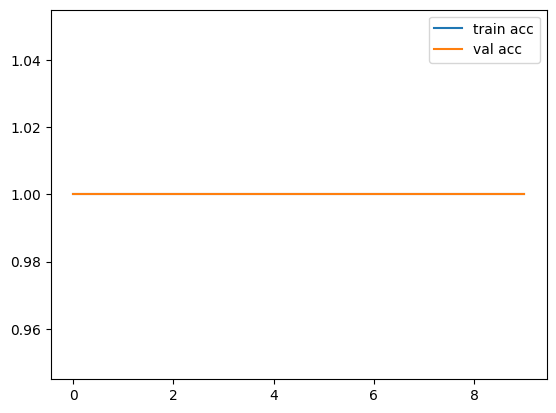

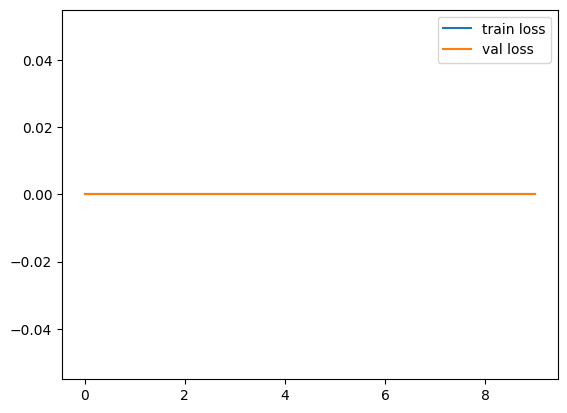

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()